## Section 1. Introduction ##

In this notebook, the dataset to be processed is the Labor Force Survey conducted April 2016 and retrieved through Philippine Statistics Authority database. 



In [2]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import h5py


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

<h1>Importing LFS PUF April 2016.CSV</h1>

In [3]:
try:
    lfs_data = pd.read_csv("src/data/LFS PUF April 2016.CSV")
except FileNotFoundError:
    print("Error: CSV file not found. Please make sure the file exists in the correct directory or provide the correct path.")
    exit()

<h1>Data Information, Pre-Processing, and Cleaning</h1>

Let's get an overview of our dataset.

In [4]:
lfs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180862 entries, 0 to 180861
Data columns (total 50 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PUFREG           180862 non-null  int64  
 1   PUFPRV           180862 non-null  int64  
 2   PUFPRRCD         180862 non-null  int64  
 3   PUFHHNUM         180862 non-null  int64  
 4   PUFURB2K10       180862 non-null  int64  
 5   PUFPWGTFIN       180862 non-null  float64
 6   PUFSVYMO         180862 non-null  int64  
 7   PUFSVYYR         180862 non-null  int64  
 8   PUFPSU           180862 non-null  int64  
 9   PUFRPL           180862 non-null  int64  
 10  PUFHHSIZE        180862 non-null  int64  
 11  PUFC01_LNO       180862 non-null  int64  
 12  PUFC03_REL       180862 non-null  int64  
 13  PUFC04_SEX       180862 non-null  int64  
 14  PUFC05_AGE       180862 non-null  int64  
 15  PUFC06_MSTAT     180862 non-null  object 
 16  PUFC07_GRADE     180862 non-null  obje

---
Of interest to us, there are:
<ul><li>1 contains float values, </li>
<li>14 contain integer values, and </li>
<li><b>35 are object values</b>.</li></ul>


---
Let's check for duplicates:

In [5]:
lfs_data.duplicated().sum()

np.int64(0)

No duplicates here, and therefore no cleaning need follow in this regard.

The dataset seems to contain null values in the form of whitespaces. Let's count those:

In [6]:
has_null = lfs_data.apply(lambda col: col.str.isspace().sum() if col.dtype == 'object' else 0)

print("Number Empty Cells:")
print(has_null[has_null > 0])

Number Empty Cells:
PUFC06_MSTAT        18339
PUFC07_GRADE        18339
PUFC08_CURSCH      107137
PUFC09_GRADTECH     57782
PUFC10_CONWR        57782
PUFC11_WORK         21894
PUFC12_JOB          93306
PUFC14_PROCC       108360
PUFC16_PKB         108360
PUFC17_NATEM       109507
PUFC18_PNWHRS      109507
PUFC19_PHOURS      109507
PUFC20_PWMORE      109507
PUFC21_PLADDW      109507
PUFC22_PFWRK       109507
PUFC23_PCLASS      109507
PUFC24_PBASIS      138947
PUFC25_PBASIC      144274
PUFC26_OJOB        109507
PUFC27_NJOBS       174924
PUFC28_THOURS      109507
PUFC29_WWM48H      163629
PUFC30_LOOKW       132692
PUFC31_FLWRK       178569
PUFC32_JOBSM       178569
PUFC33_WEEKS       178569
PUFC34_WYNOT       134985
PUFC35_LTLOOKW     179269
PUFC36_AVAIL       174893
PUFC37_WILLING     174893
PUFC38_PREVJOB     132692
PUFC40_POCC        152982
PUFC41_WQTR         81627
PUFC43_QKB         107825
PUFNEWEMPSTAT       61337
dtype: int64


---
And standardize, replacing these whitespace values with -1:

In [7]:
lfs_data.replace(r"^\s+$", -1, regex=True, inplace=True)
nan_counts_per_column = lfs_data.isna().sum()
print(nan_counts_per_column[nan_counts_per_column > 0])

Series([], dtype: int64)


Now that these are -1, let's return to the data types, and find if our object columns from earlier are convertible to integers (or float):

In [8]:
int_convertible_columns = []

for col in lfs_data.columns:
    if lfs_data[col].dtypes == 'object':  
        try:
            float_vals = lfs_data[col].dropna().astype(float)
            if (float_vals % 1 == 0).all():
                int_convertible_columns.append(col)
        except ValueError:
            pass 

print("Safely convertable to int:")
print(int_convertible_columns)

Safely convertable to int:
['PUFC06_MSTAT', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC10_CONWR', 'PUFC11_WORK', 'PUFC12_JOB', 'PUFC14_PROCC', 'PUFC16_PKB', 'PUFC17_NATEM', 'PUFC18_PNWHRS', 'PUFC19_PHOURS', 'PUFC20_PWMORE', 'PUFC21_PLADDW', 'PUFC22_PFWRK', 'PUFC23_PCLASS', 'PUFC24_PBASIS', 'PUFC25_PBASIC', 'PUFC26_OJOB', 'PUFC27_NJOBS', 'PUFC28_THOURS', 'PUFC29_WWM48H', 'PUFC30_LOOKW', 'PUFC31_FLWRK', 'PUFC32_JOBSM', 'PUFC33_WEEKS', 'PUFC34_WYNOT', 'PUFC35_LTLOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING', 'PUFC38_PREVJOB', 'PUFC40_POCC', 'PUFC41_WQTR', 'PUFC43_QKB', 'PUFNEWEMPSTAT']


---
And convert to int

In [9]:
columns_to_convert = [
    'PUFC06_MSTAT', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC10_CONWR', 'PUFC11_WORK', 
    'PUFC12_JOB', 'PUFC14_PROCC', 'PUFC16_PKB', 'PUFC17_NATEM', 'PUFC18_PNWHRS', 
    'PUFC19_PHOURS', 'PUFC20_PWMORE', 'PUFC21_PLADDW', 'PUFC22_PFWRK', 'PUFC23_PCLASS', 
    'PUFC24_PBASIS', 'PUFC25_PBASIC', 'PUFC26_OJOB', 'PUFC27_NJOBS', 'PUFC28_THOURS', 
    'PUFC29_WWM48H', 'PUFC30_LOOKW', 'PUFC31_FLWRK', 'PUFC32_JOBSM', 'PUFC33_WEEKS', 
    'PUFC34_WYNOT', 'PUFC35_LTLOOKW', 'PUFC36_AVAIL', 'PUFC37_WILLING', 'PUFC38_PREVJOB', 
    'PUFC40_POCC', 'PUFC41_WQTR', 'PUFC43_QKB', 'PUFNEWEMPSTAT'
]

for col in columns_to_convert:
    lfs_data[col] = lfs_data[col].astype(int) 

---
Let's also apply the unique() function to our dataset.

In [10]:
lfs_data.apply(lambda x: x.nunique())

PUFREG                17
PUFPRV                86
PUFPRRCD             116
PUFHHNUM           40880
PUFURB2K10             2
PUFPWGTFIN         35599
PUFSVYMO               1
PUFSVYYR               1
PUFPSU               975
PUFRPL                 4
PUFHHSIZE             20
PUFC01_LNO            23
PUFC03_REL            11
PUFC04_SEX             2
PUFC05_AGE           100
PUFC06_MSTAT           7
PUFC07_GRADE          68
PUFC08_CURSCH          3
PUFC09_GRADTECH        3
PUFC10_CONWR           6
PUFC11_WORK            3
PUFC12_JOB             3
PUFC14_PROCC          44
PUFC16_PKB            88
PUFC17_NATEM           4
PUFC18_PNWHRS         17
PUFC19_PHOURS        103
PUFC20_PWMORE          3
PUFC21_PLADDW          3
PUFC22_PFWRK           3
PUFC23_PCLASS          8
PUFC24_PBASIS          9
PUFC25_PBASIC       1152
PUFC26_OJOB            3
PUFC27_NJOBS           6
PUFC28_THOURS        111
PUFC29_WWM48H          6
PUFC30_LOOKW           3
PUFC31_FLWRK           3
PUFC32_JOBSM           7


---
Considering our dataset has 18,000 entries, features with particularly low numbers stand out as questions that have clear, defined choices. Reviewing the [questionnaire](https://psada.psa.gov.ph/catalog/67/download/537), we find that certain questions ask the participant to specify beyond prespecified choices.

This column possibly contains "010," which is obviously not an integer. We ensure this column is a string, and check for values not specified in the questionnaire.

In [11]:
lfs_data['PUFC07_GRADE'] = lfs_data['PUFC07_GRADE']
valid_codes = [
    0, 10,  # No Grade, Preschool
    210, 220, 230, 240, 250, 260, 280,  # Elementary
    310, 320, 330, 340, 350,  # High School
    410, 420,  # Post Secondary; If Graduate Specify
    810, 820, 830, 840,  # College; If Graduate Specify
    900,  # Post Baccalaureate
    np.nan
]
invalid_rows = lfs_data[~(lfs_data['PUFC07_GRADE'].isin(valid_codes))]

unique_invalid_values = invalid_rows['PUFC07_GRADE'].unique()
print(unique_invalid_values)

['350' '320' '250' -1 '622' '672' '240' '220' '614' '330' '010' '280'
 '632' '310' '000' '900' '820' '230' '589' '572' '210' '830' '810' '634'
 '686' '581' '681' '552' '534' '840' '658' '548' '648' '652' '662' '601'
 '642' '562' '260' '685' '631' '684' '340' '584' '621' '410' '420' '664'
 '676' '521' '638' '554' '646' '689' '522' '654' '644' '532' '531' '514'
 '558' '501' '586' '542' '576' '544' '585' '564']


Values 5XX 6XX are not detailed in the questionnaire. As it instructs the participant to specify whether they graduated from post secondary or college, we'll create a new data point to encapsulate these.

In [12]:
lfs_data.loc[~lfs_data['PUFC07_GRADE'].isin(valid_codes), 'PUFC07_GRADE'] = 700
print(lfs_data['PUFC07_GRADE'].unique())

[700]


In [13]:
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == " ", 'PUFC30_LOOKW'] = -1
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == "1", 'PUFC30_LOOKW'] = 1
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == "2", 'PUFC30_LOOKW'] = 2
lfs_data.loc[lfs_data['PUFC30_LOOKW'] == -1, 'PUFC30_LOOKW'] = 1

## EDA

In [14]:
lfs_data_with_nan = lfs_data.copy()
lfs_data_with_nan.replace(-1, np.nan, inplace=True)
corr_matrix = lfs_data_with_nan.corr()

strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)): 
        corr_value = corr_matrix.iloc[i, j]
        if (0.5 < corr_value < 1) or (-1 < corr_value < -0.5):
            strong_correlations.append((
                corr_matrix.index[i], 
                corr_matrix.columns[j], 
                corr_value
            ))

strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

print("Strong correlations (|corr| > 0.5 and |corr| < 1):")
for var1, var2, corr in strong_correlations:
    print(f"{var1} — {var2}: {corr:.3f}")


Strong correlations (|corr| > 0.5 and |corr| < 1):
PUFPRV — PUFPRRCD: 1.000
PUFREG — PUFHHNUM: 0.995
PUFC30_LOOKW — PUFNEWEMPSTAT: 0.976
PUFC19_PHOURS — PUFC28_THOURS: 0.972
PUFC16_PKB — PUFC43_QKB: 0.969
PUFC11_WORK — PUFNEWEMPSTAT: 0.964
PUFC41_WQTR — PUFNEWEMPSTAT: 0.878
PUFC30_LOOKW — PUFC41_WQTR: 0.857
PUFC11_WORK — PUFC41_WQTR: 0.852
PUFC31_FLWRK — PUFC38_PREVJOB: -0.795
PUFC36_AVAIL — PUFC37_WILLING: 0.785
PUFC37_WILLING — PUFNEWEMPSTAT: 0.785
PUFC18_PNWHRS — PUFC19_PHOURS: 0.785
PUFC18_PNWHRS — PUFC28_THOURS: 0.769
PUFPWGTFIN — PUFPSU: 0.709
PUFC12_JOB — PUFNEWEMPSTAT: 0.704
PUFC05_AGE — PUFC06_MSTAT: 0.701
PUFC34_WYNOT — PUFNEWEMPSTAT: 0.631
PUFC01_LNO — PUFC03_REL: 0.625
PUFC05_AGE — PUFC08_CURSCH: 0.590
PUFC11_WORK — PUFC30_LOOKW: 0.575
PUFHHSIZE — PUFC01_LNO: 0.571
PUFC01_LNO — PUFC05_AGE: -0.567
PUFC20_PWMORE — PUFC21_PLADDW: 0.556
PUFC08_CURSCH — PUFC11_WORK: -0.514
PUFC08_CURSCH — PUFC34_WYNOT: -0.510
PUFC08_CURSCH — PUFNEWEMPSTAT: -0.509


# Preprocessing:

We will use feature_cols as our predictor variables for PUFC11_WORK. Using Regression, we will evaluate how well we can predict whether or not someone has worked in the past week. We begin with preprocessing.

### Logistic Regression
Because this is a classification task, we can choose Logistic Regression as a baseline and a first model.

We create a copy of our target variable PUFC11_WORK, and create a 80-20 train-test split for the non-empty PUFC11 data we have. We'll also standardize the values to minimize the impact of differing ranges of values on our model. We also map the values of PUFC11, normally [1,2], to [0,1]. In addition, because we've determined that our feature_cols are intentionally unanswered as appropriate, we will be treating these values as empty rather than imputing.

In [15]:
from src.preprocessing import prepare_data

target_col = 'PUFC11_WORK'
feature_cols = [
    'PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 
    'PUFC07_GRADE', 'PUFC08_CURSCH', 
    'PUFC38_PREVJOB', 'PUFC31_FLWRK',
    'PUFC30_LOOKW', 'PUFC34_WYNOT'
]

test_size = 0.2
missing_value =-1
seed = 45

data_dict = prepare_data(lfs_data, target_col = target_col,
                         test_size = test_size,
                         missing_value = missing_value,
                         feature_cols = feature_cols,
                         seed = seed)

Preparing data...
Training on 7 samples with 12 features
Features: ['PUFC05_AGE', 'PUFC06_MSTAT', 'PUFC04_SEX', 'PUFC07_GRADE', 'PUFC08_CURSCH', 'PUFC38_PREVJOB', 'PUFC31_FLWRK', 'PUFC30_LOOKW', 'PUFC34_WYNOT']


#### Training
We are ready to start training. As we are setting a baseline, we'll start off with these hyperparameters. We'll use Stochastic Gradient Descent as our specified optimizer, though technically implementing mini-batch with a batch size of 128. We are looking for improvements in loss greater than 0.0001, else we stop early within three epochs. Lastly, we use a weight_decay of 0, indicating no regularization for now. All hyperparameters indicated below also indicate their default value if unspecified.

In [16]:
from src.trainEval import *
result_dict = train_model(
    data_dict,
    model = "lr",
    
   
    optimizer = "sgd",
    batch_size=128,

    scheduler_step_size=5,
    learning_rate=0.01,  
    scheduler_gamma=0.5,
    convergence_threshold=1e-4, 
    num_epochs=50,  
    patience=3,
    weight_decay = 0,
    seed = seed
    
)

print("\nModel training complete!")

Epoch 1/50: Train Loss: 0.3946, Test Loss: 0.2926, Train Acc: 0.8906, Test Acc: 0.9384, LR: 0.010000
Epoch 2/50: Train Loss: 0.2644, Test Loss: 0.2422, Train Acc: 0.9425, Test Acc: 0.9471, LR: 0.010000
Epoch 3/50: Train Loss: 0.2296, Test Loss: 0.2169, Train Acc: 0.9534, Test Acc: 0.9567, LR: 0.010000
Epoch 4/50: Train Loss: 0.2095, Test Loss: 0.2005, Train Acc: 0.9594, Test Acc: 0.9602, LR: 0.010000
Epoch 5/50: Train Loss: 0.1959, Test Loss: 0.1887, Train Acc: 0.9624, Test Acc: 0.9637, LR: 0.005000
Epoch 6/50: Train Loss: 0.1880, Test Loss: 0.1839, Train Acc: 0.9645, Test Acc: 0.9653, LR: 0.005000
Epoch 7/50: Train Loss: 0.1836, Test Loss: 0.1797, Train Acc: 0.9654, Test Acc: 0.9653, LR: 0.005000
Epoch 8/50: Train Loss: 0.1797, Test Loss: 0.1759, Train Acc: 0.9659, Test Acc: 0.9658, LR: 0.005000
Epoch 9/50: Train Loss: 0.1762, Test Loss: 0.1725, Train Acc: 0.9663, Test Acc: 0.9661, LR: 0.005000
Epoch 10/50: Train Loss: 0.1730, Test Loss: 0.1694, Train Acc: 0.9664, Test Acc: 0.9662, LR

#### Error
For both classes 0 (did not work in the past week) and 1 (did work in the past week), the initial model performed well. Precision and F1-Score are both within 1% for the ratios of class 0 to 1. The only metric of particular note is our recall, with scores of 0.94 to 0.98, indicating that we're somewhat better at avoiding false negatives for predicting those who did work rather than for those who didnt.


In [21]:
hyperparameter_results = hyperparameter_random_search(data_dict)
best_params = hyperparameter_results['best_params']
results_summary = hyperparameter_results['summary_df']

final_model = train_model(
    data_dict, 
    **best_params
)


Testing configuration:
{'weight_decay': np.float64(0.004641588833612777), 'scheduler_step_size': 5, 'scheduler_gamma': 0.5, 'patience': 7, 'optimizer': 'adam', 'num_epochs': 75, 'model': 'lr', 'learning_rate': np.float64(0.04832930238571752), 'batch_size': 64}
Epoch 1/75: Train Loss: 0.1717, Test Loss: 0.1597, Train Acc: 0.9657, Test Acc: 0.9645, LR: 0.048329


KeyboardInterrupt: 

Decision Tree

split train and test 

In [22]:
X_train, X_test, y_train, y_test = (data_dict['X_train'], 
                                    data_dict['X_test'], 
                                    data_dict['y_train'], 
                                    data_dict['y_test'])
                                    
model = DecisionTreeClassifier(random_state=45, min_impurity_decrease=0.001)



train

In [23]:
model.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=0.001, random_state=45)

initial predictions

In [24]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy:.4f}")


print(classification_report(y_test, y_pred))

acc: 0.9857
              precision    recall  f1-score   support

           1       0.99      0.98      0.98     14302
           2       0.99      0.99      0.99     17492

    accuracy                           0.99     31794
   macro avg       0.99      0.99      0.99     31794
weighted avg       0.99      0.99      0.99     31794



hyperparameter tuning



In [25]:
p_grid = {
    "criterion": ["gini", "entropy"],  
    "max_depth": [30, 45, 50, 60],  
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4], 
    "min_impurity_decrease": [0.001, 0.005, 0.01], ## ensures pruning
    "ccp_alpha": np.logspace(-4, 0, 10)
}

random_search = RandomizedSearchCV(model, p_grid, n_iter=20, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, random_state=45)
random_search.fit(X_train, y_train)

## best params 
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_depth': 45, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.12915496650148828)}


In [ ]:
best_model = DecisionTreeClassifier(**random_search.best_params_, random_state=seed)

best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)

confirm

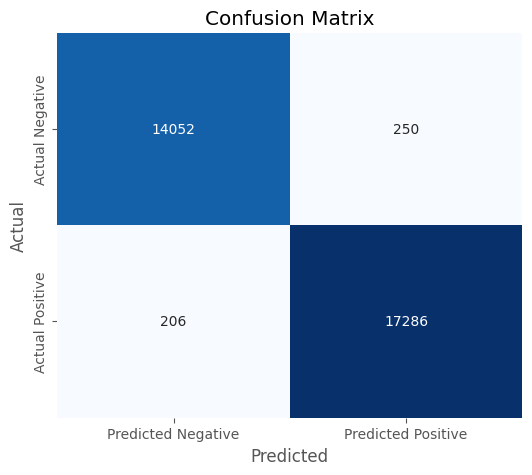

[[14052   250]
 [  206 17286]]
Training Accuracy: 0.9862
Test Accuracy: 0.9857
Training Log Loss: 0.0671
Test Log Loss: 0.0689


In [ ]:
train_preds = best_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

test_preds = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)

train_probs = best_model.predict_proba(X_train)
test_probs = best_model.predict_proba(X_test)
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

print(cm)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


print(f"Training Log Loss: {train_loss:.4f}")
print(f"Test Log Loss: {test_loss:.4f}")



check class imbalance

In [28]:
print("distrib w/ numpy:", np.bincount(y_train))

## not too large difference between 1 and 2, thereby with the model already handling it well, no need to change certain characteristics
## no need for pruning due to extremely low acc diff on training and test set

distrib w/ numpy: [    0 57110 70064]


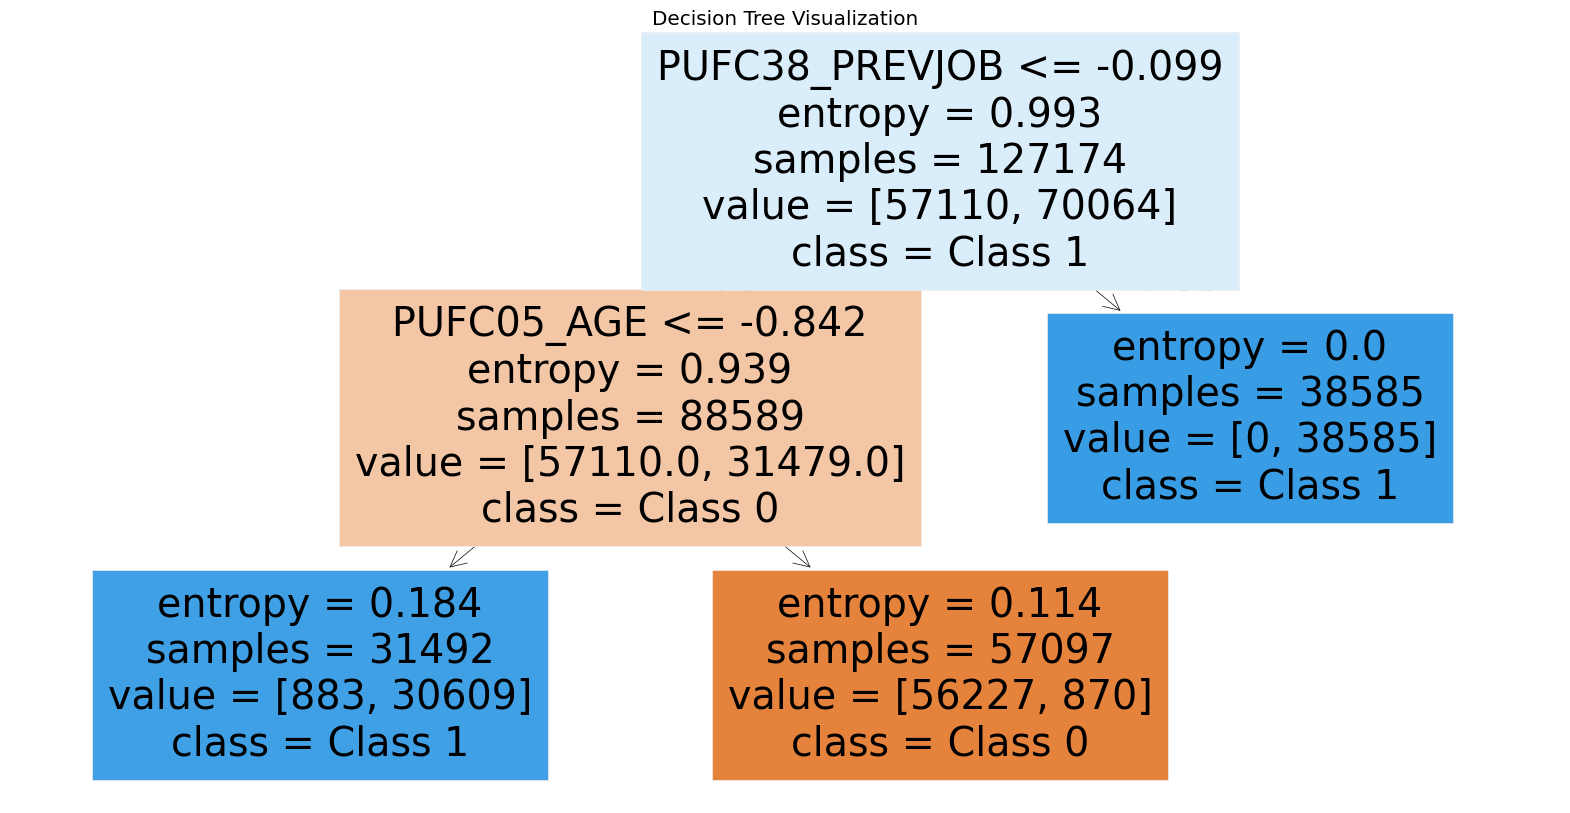

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X_train.columns, class_names=["Class 0", "Class 1"])
plt.title("Decision Tree Visualization")
plt.show()